<a href="https://colab.research.google.com/github/Syed-Osama-Hussain/Imagined-Speech-Prediction-from-EEG/blob/master/Combined_matrices_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import scipy.io
import os
from google.colab import drive
import keras as ks
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, MaxPooling1D
from sklearn.utils import shuffle
from keras.layers import LSTM, Dropout, GRU, Input, Reshape
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers.merge import concatenate
from keras.models import Model
import keras.backend as K
from tensorflow.keras.optimizers import Adam

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
def covariance(matrix):
  res_mat = np.cov(matrix,bias=True)
  return res_mat

In [4]:
def loadMatricesLong(dir):
  matrices_c1 = []
  matrices_c2 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      if f == "Read_me.txt":
        continue
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2)),axis=0)

In [5]:
def loadMatricesShort(dir):
  matrices_c1 = []
  matrices_c2 = []
  matrices_c3 = []
  for root,sub,files in os.walk(dir):
    for f in sorted(files):
      mat_file  =  scipy.io.loadmat(os.path.join(root, f))
      end_trial = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_end_trial']
      last_beep = mat_file['eeg_data_wrt_task_rep_no_eog_256Hz_last_beep']
      matrices_c1.extend([covariance(matrix) for matrix in end_trial[0]])
      matrices_c1.extend([covariance(matrix) for matrix in last_beep[0]])
      matrices_c2.extend([covariance(matrix) for matrix in end_trial[1]])
      matrices_c2.extend([covariance(matrix) for matrix in last_beep[1]])
      matrices_c3.extend([covariance(matrix) for matrix in end_trial[2]])
      matrices_c3.extend([covariance(matrix) for matrix in last_beep[2]])
  return np.concatenate((np.array(matrices_c1),np.array(matrices_c2),np.array(matrices_c3)),axis=0)

#SHORT CLASSES (OUT, IN, UP) LONG CLASSES (COOPERATE, INDEPENDENT)

In [6]:
def loadMatrices():
  short_mat=[]
  long_mat=[]
  
  short_mat = loadMatricesShort("drive/My Drive/dataset/Short_words/")
  long_mat = loadMatricesLong("drive/My Drive/dataset/Long_words/")
  return np.concatenate((short_mat,long_mat),axis=0)


In [7]:
train_data = loadMatrices()

In [8]:
train_data.shape

(5000, 64, 64)

In [9]:
labels = np.concatenate((np.zeros(1000),np.ones(1000),np.full(1000,2),np.full(1000,3),np.full(1000,4)),axis=0)
print(labels)

[0. 0. 0. ... 4. 4. 4.]


In [10]:
from keras.utils.np_utils import to_categorical
labels = to_categorical(labels, num_classes=5)
# labels = to_categorical(labels, num_classes=2)
print(labels.shape,labels)

(5000, 5) [[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]


In [11]:
visible = Input(shape=(64,64))
#CNN
cov1 = Conv1D(filters=64, kernel_size=2, activation="relu")(visible)
cov2 = Conv1D(filters=64, kernel_size=4, activation="relu")(cov1)
newShape = Reshape((60,64), name='newReshape')(cov2)
f1 = Flatten()(newShape)
d1 = Dense(128, activation='relu')(f1)
d2 = Dense(128, activation='relu')(d1)

#RNN
lstm1 = GRU(64,activation="relu",return_sequences=True)(visible)
lstm2 = GRU(64,activation="relu")(lstm1)
d3 = Dense(64, activation='relu')(lstm2)
d4 = Dense(64, activation='relu')(d3)
#Merge
merge = concatenate([d2, d4])

#DAE
encoder1 = Dense(768, activation='relu')(merge)
encoder2 = Dense(96, activation='relu')(encoder1)
decoder1 = Dense(768, activation='relu')(encoder2)
decoder2 = Dense(192, activation='relu')(decoder1)

#FNN
hidden1 = Dense(64, activation='relu')(encoder2)
hidden2 = Dense(64, activation='relu')(hidden1)
output = Dense(5, activation='softmax')(hidden2)
model = Model(inputs=visible, outputs=output)
print(model.summary())

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 63, 64)       8256        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 60, 64)       16448       conv1d[0][0]                     
__________________________________________________________________________________________________
newReshape (Reshape)            (None, 60, 64)       0           conv1d_1[0][0]                   
_______________________________________________________________________________________

In [12]:
optimizer = Adam(learning_rate=0.00001)

In [13]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
data, labels = shuffle(train_data, labels)

In [15]:
print(labels.shape,data.shape)

(5000, 5) (5000, 64, 64)


In [16]:
y_test = labels[0:30]
x_test = data[0:30]
train_data = data[30:len(data)]
train_labels = labels[30:len(labels)]

In [17]:
print(y_test.shape,x_test.shape,train_data.shape,train_labels.shape)

(30, 5) (30, 64, 64) (4970, 64, 64) (4970, 5)


Iteration no  0  for training 
Epoch 1/100
125/125 [==============================] - 10s 80ms/step - loss: 17.6585 - accuracy: 0.2326 - val_loss: 95.0255 - val_accuracy: 0.2968
Epoch 2/100
125/125 [==============================] - 10s 77ms/step - loss: 3.9537 - accuracy: 0.3207 - val_loss: 23.0777 - val_accuracy: 0.3199
Epoch 3/100
125/125 [==============================] - 10s 76ms/step - loss: 3.9377 - accuracy: 0.3350 - val_loss: 105.7116 - val_accuracy: 0.3491
Epoch 4/100
125/125 [==============================] - 9s 76ms/step - loss: 3.4157 - accuracy: 0.3617 - val_loss: 60.1552 - val_accuracy: 0.3350
Epoch 5/100
125/125 [==============================] - 10s 77ms/step - loss: 2.4463 - accuracy: 0.3720 - val_loss: 30.1391 - val_accuracy: 0.3551
Epoch 6/100
125/125 [==============================] - 10s 77ms/step - loss: 2.0668 - accuracy: 0.3934 - val_loss: 28.2342 - val_accuracy: 0.3682
Epoch 7/100
125/125 [==============================] - 10s 77ms/step - loss: 1.9288 - accura

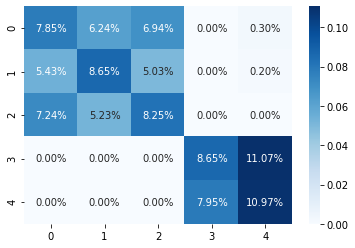

Iteration no  1  for training 
Epoch 1/100
125/125 [==============================] - 10s 78ms/step - loss: 0.9409 - accuracy: 0.5350 - val_loss: 1.9145 - val_accuracy: 0.4909
Epoch 2/100
125/125 [==============================] - 10s 81ms/step - loss: 0.9235 - accuracy: 0.5430 - val_loss: 1.8486 - val_accuracy: 0.4930
Epoch 3/100
125/125 [==============================] - 10s 82ms/step - loss: 0.9081 - accuracy: 0.5536 - val_loss: 1.7804 - val_accuracy: 0.4829
Epoch 4/100
125/125 [==============================] - 10s 79ms/step - loss: 0.9002 - accuracy: 0.5553 - val_loss: 1.7305 - val_accuracy: 0.4829
Epoch 5/100
125/125 [==============================] - 10s 78ms/step - loss: 0.8893 - accuracy: 0.5621 - val_loss: 1.6671 - val_accuracy: 0.5091
Epoch 6/100
125/125 [==============================] - 10s 78ms/step - loss: 0.8859 - accuracy: 0.5541 - val_loss: 51.1679 - val_accuracy: 0.4940
Epoch 7/100
125/125 [==============================] - 10s 78ms/step - loss: 0.9155 - accuracy: 0.

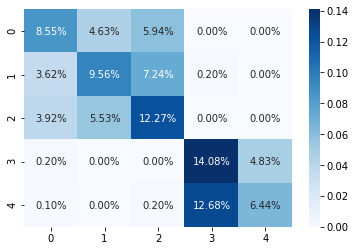

Iteration no  2  for training 
Epoch 1/100
125/125 [==============================] - 10s 78ms/step - loss: 1.8334 - accuracy: 0.6403 - val_loss: 0.7746 - val_accuracy: 0.6207
Epoch 2/100
125/125 [==============================] - 10s 77ms/step - loss: 31.8474 - accuracy: 0.6195 - val_loss: 0.7722 - val_accuracy: 0.6288
Epoch 3/100
125/125 [==============================] - 10s 77ms/step - loss: 15.9990 - accuracy: 0.5951 - val_loss: 0.9004 - val_accuracy: 0.6046
Epoch 4/100
125/125 [==============================] - 10s 78ms/step - loss: 3.8889 - accuracy: 0.6026 - val_loss: 0.7885 - val_accuracy: 0.6036
Epoch 5/100
125/125 [==============================] - 10s 77ms/step - loss: 0.7859 - accuracy: 0.6240 - val_loss: 0.8468 - val_accuracy: 0.5946
Epoch 6/100
125/125 [==============================] - 10s 77ms/step - loss: 1.3116 - accuracy: 0.6127 - val_loss: 0.8188 - val_accuracy: 0.5946
Epoch 7/100
125/125 [==============================] - 10s 77ms/step - loss: 0.9263 - accuracy: 0

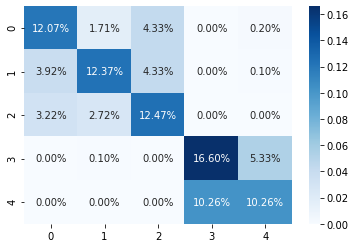

Iteration no  3  for training 
Epoch 1/100
125/125 [==============================] - 11s 85ms/step - loss: 0.7343 - accuracy: 0.7304 - val_loss: 0.6790 - val_accuracy: 0.7233
Epoch 2/100
125/125 [==============================] - 10s 78ms/step - loss: 0.6858 - accuracy: 0.7402 - val_loss: 0.6394 - val_accuracy: 0.7404
Epoch 3/100
125/125 [==============================] - 10s 80ms/step - loss: 0.6589 - accuracy: 0.7513 - val_loss: 0.6248 - val_accuracy: 0.7254
Epoch 4/100
125/125 [==============================] - 10s 79ms/step - loss: 0.6204 - accuracy: 0.7535 - val_loss: 0.6026 - val_accuracy: 0.7314
Epoch 5/100
125/125 [==============================] - 10s 78ms/step - loss: 0.5882 - accuracy: 0.7570 - val_loss: 0.5959 - val_accuracy: 0.7243
Epoch 6/100
125/125 [==============================] - 10s 78ms/step - loss: 0.5635 - accuracy: 0.7460 - val_loss: 0.5891 - val_accuracy: 0.7364
Epoch 7/100
125/125 [==============================] - 10s 78ms/step - loss: 0.5418 - accuracy: 0.7

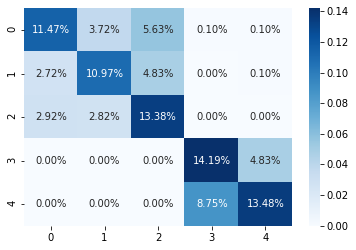

Iteration no  4  for training 
Epoch 1/100
125/125 [==============================] - 10s 80ms/step - loss: 0.5344 - accuracy: 0.7923 - val_loss: 2.0103 - val_accuracy: 0.7767
Epoch 2/100
125/125 [==============================] - 10s 79ms/step - loss: 0.5016 - accuracy: 0.7960 - val_loss: 1.9420 - val_accuracy: 0.7626
Epoch 3/100
125/125 [==============================] - 10s 79ms/step - loss: 0.4754 - accuracy: 0.8043 - val_loss: 1.6358 - val_accuracy: 0.7907
Epoch 4/100
125/125 [==============================] - 10s 79ms/step - loss: 0.4648 - accuracy: 0.8114 - val_loss: 1.4244 - val_accuracy: 0.7807
Epoch 5/100
125/125 [==============================] - 10s 79ms/step - loss: 0.4588 - accuracy: 0.8104 - val_loss: 1.3437 - val_accuracy: 0.7807
Epoch 6/100
125/125 [==============================] - 10s 81ms/step - loss: 0.4481 - accuracy: 0.8151 - val_loss: 1.2137 - val_accuracy: 0.7807
Epoch 7/100
125/125 [==============================] - 10s 78ms/step - loss: 0.4763 - accuracy: 0.8

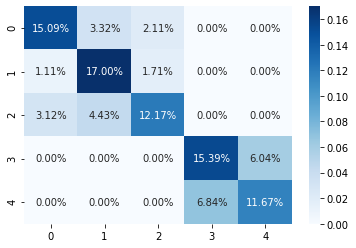

Iteration no  5  for training 
Epoch 1/100
125/125 [==============================] - 10s 78ms/step - loss: 0.3682 - accuracy: 0.8509 - val_loss: 0.4215 - val_accuracy: 0.8390
Epoch 2/100
125/125 [==============================] - 10s 79ms/step - loss: 0.3921 - accuracy: 0.8466 - val_loss: 0.5157 - val_accuracy: 0.8360
Epoch 3/100
125/125 [==============================] - 10s 78ms/step - loss: 0.3334 - accuracy: 0.8685 - val_loss: 0.4363 - val_accuracy: 0.8702
Epoch 4/100
125/125 [==============================] - 10s 79ms/step - loss: 0.3478 - accuracy: 0.8637 - val_loss: 0.3799 - val_accuracy: 0.8571
Epoch 5/100
125/125 [==============================] - 10s 79ms/step - loss: 0.3290 - accuracy: 0.8675 - val_loss: 0.5353 - val_accuracy: 0.8652
Epoch 6/100
125/125 [==============================] - 10s 79ms/step - loss: 0.3120 - accuracy: 0.8798 - val_loss: 0.4338 - val_accuracy: 0.8753
Epoch 7/100
125/125 [==============================] - 10s 79ms/step - loss: 0.2879 - accuracy: 0.8

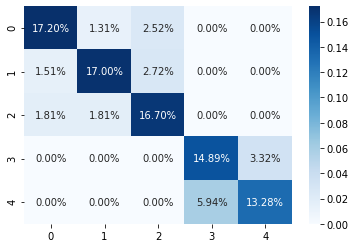

Iteration no  6  for training 
Epoch 1/100
125/125 [==============================] - 10s 77ms/step - loss: 21.2297 - accuracy: 0.8647 - val_loss: 0.9717 - val_accuracy: 0.8924
Epoch 2/100
125/125 [==============================] - 10s 77ms/step - loss: 1.9794 - accuracy: 0.8332 - val_loss: 1.0196 - val_accuracy: 0.7928
Epoch 3/100
125/125 [==============================] - 10s 78ms/step - loss: 1.4267 - accuracy: 0.8043 - val_loss: 2.0104 - val_accuracy: 0.7586
Epoch 4/100
125/125 [==============================] - 11s 90ms/step - loss: 0.6676 - accuracy: 0.8051 - val_loss: 1.7049 - val_accuracy: 0.8169
Epoch 5/100
125/125 [==============================] - 10s 78ms/step - loss: 0.4654 - accuracy: 0.8368 - val_loss: 1.4193 - val_accuracy: 0.8199
Epoch 6/100
125/125 [==============================] - 10s 78ms/step - loss: 0.3766 - accuracy: 0.8551 - val_loss: 1.0867 - val_accuracy: 0.8571
Epoch 7/100
125/125 [==============================] - 10s 79ms/step - loss: 0.4470 - accuracy: 0.

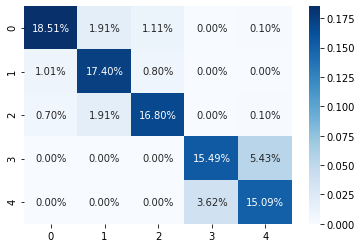

Iteration no  7  for training 
Epoch 1/100
125/125 [==============================] - 10s 80ms/step - loss: 0.3759 - accuracy: 0.9092 - val_loss: 0.2416 - val_accuracy: 0.9085
Epoch 2/100
125/125 [==============================] - 10s 82ms/step - loss: 0.2677 - accuracy: 0.9278 - val_loss: 1.5389 - val_accuracy: 0.9225
Epoch 3/100
125/125 [==============================] - 11s 91ms/step - loss: 0.2012 - accuracy: 0.9429 - val_loss: 3.9740 - val_accuracy: 0.8954
Epoch 4/100
125/125 [==============================] - 11s 87ms/step - loss: 0.1732 - accuracy: 0.9416 - val_loss: 0.2392 - val_accuracy: 0.9165
Epoch 5/100
125/125 [==============================] - 10s 82ms/step - loss: 0.2058 - accuracy: 0.9454 - val_loss: 3.3029 - val_accuracy: 0.9135
Epoch 6/100
125/125 [==============================] - 10s 82ms/step - loss: 0.3416 - accuracy: 0.9399 - val_loss: 30.8483 - val_accuracy: 0.9135
Epoch 7/100
125/125 [==============================] - 11s 86ms/step - loss: 0.6233 - accuracy: 0.

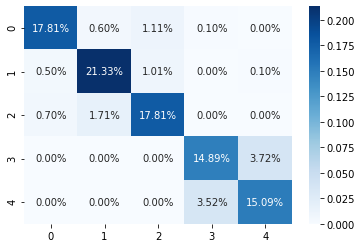

Iteration no  8  for training 
Epoch 1/100
125/125 [==============================] - 10s 79ms/step - loss: 0.2617 - accuracy: 0.9364 - val_loss: 0.2046 - val_accuracy: 0.9457
Epoch 2/100
125/125 [==============================] - 10s 79ms/step - loss: 0.1914 - accuracy: 0.9580 - val_loss: 0.1989 - val_accuracy: 0.9567
Epoch 3/100
125/125 [==============================] - 10s 79ms/step - loss: 0.1702 - accuracy: 0.9582 - val_loss: 0.1919 - val_accuracy: 0.9547
Epoch 4/100
125/125 [==============================] - 10s 84ms/step - loss: 0.1678 - accuracy: 0.9527 - val_loss: 0.1798 - val_accuracy: 0.9557
Epoch 5/100
125/125 [==============================] - 10s 80ms/step - loss: 0.1612 - accuracy: 0.9505 - val_loss: 0.1628 - val_accuracy: 0.9507
Epoch 6/100
125/125 [==============================] - 10s 80ms/step - loss: 0.1333 - accuracy: 0.9580 - val_loss: 0.3462 - val_accuracy: 0.9457
Epoch 7/100
125/125 [==============================] - 10s 79ms/step - loss: 0.1300 - accuracy: 0.9

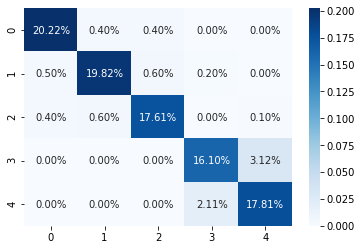

Iteration no  9  for training 
Epoch 1/100
125/125 [==============================] - 10s 79ms/step - loss: 0.3745 - accuracy: 0.9291 - val_loss: 0.4346 - val_accuracy: 0.8843
Epoch 2/100
125/125 [==============================] - 10s 79ms/step - loss: 0.6287 - accuracy: 0.8951 - val_loss: 0.3402 - val_accuracy: 0.8873
Epoch 3/100
125/125 [==============================] - 10s 79ms/step - loss: 0.2545 - accuracy: 0.9411 - val_loss: 0.1923 - val_accuracy: 0.9366
Epoch 4/100
125/125 [==============================] - 10s 78ms/step - loss: 0.1383 - accuracy: 0.9665 - val_loss: 0.2724 - val_accuracy: 0.9044
Epoch 5/100
125/125 [==============================] - 10s 78ms/step - loss: 0.2788 - accuracy: 0.9487 - val_loss: 0.1761 - val_accuracy: 0.9467
Epoch 6/100
125/125 [==============================] - 10s 77ms/step - loss: 0.1962 - accuracy: 0.9620 - val_loss: 0.2355 - val_accuracy: 0.9276
Epoch 7/100
125/125 [==============================] - 10s 76ms/step - loss: 0.1476 - accuracy: 0.9

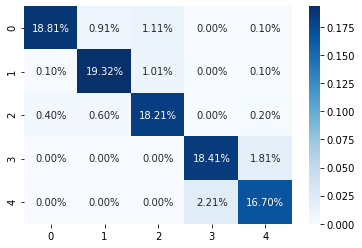

In [18]:
histories = []
for i in range(10):
  print("Iteration no ",i," for training \n=========\n=========\n=========")

  train_data, train_labels = shuffle(train_data, train_labels)

  divide_percent=(len(train_data)*0.2)
  x_val=train_data[0:int(divide_percent)]
  y_val=train_labels[0:int(divide_percent)]
  x_train = train_data[int(divide_percent):len(train_data)]
  y_train = train_labels[int(divide_percent):len(train_labels)]
  
  history = model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=100,verbose=1)
  histories.append(history)
  predictions = model.predict(x_val,verbose=0)
  np.round(predictions)
  rounded_labels = np.argmax(y_val, axis=1)
  rounded_predictions = np.argmax(predictions, axis=1)
  cf = confusion_matrix(rounded_labels,rounded_predictions)  # doctest: +SKIP
  sns.heatmap(cf/np.sum(cf), annot=True, fmt='.2%', cmap='Blues')
  # print("Loss Comparison ====================================================")
  # plt.plot(history.history['loss'])
  # plt.plot(history.history['val_loss'])
  # plt.title('model train vs validation loss')
  # plt.ylabel('loss')
  # plt.xlabel('epoch')
  # plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

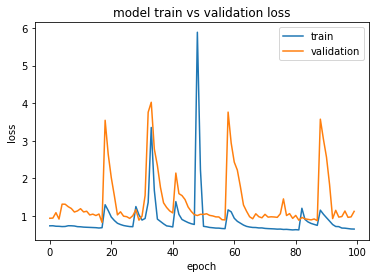

In [ ]:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

In [19]:
model.save("combine_model.h5")

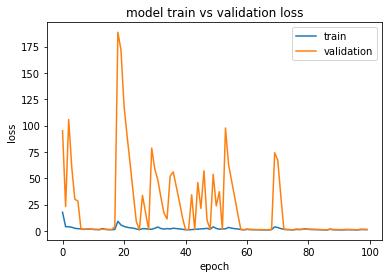

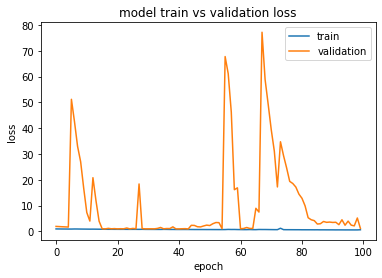

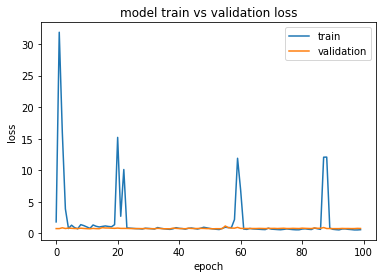

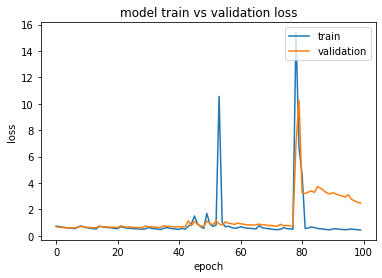

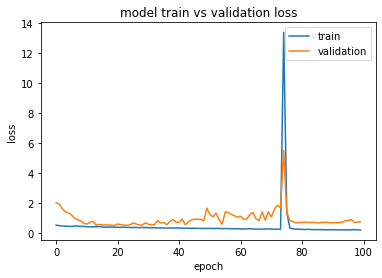

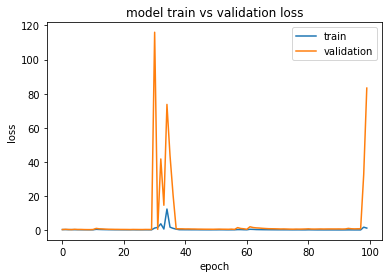

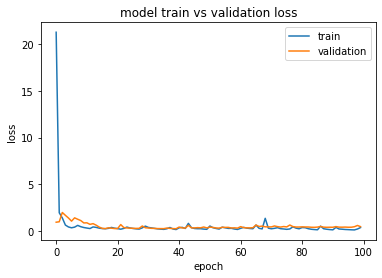

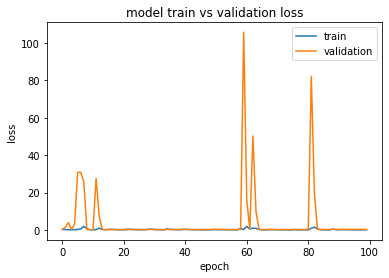

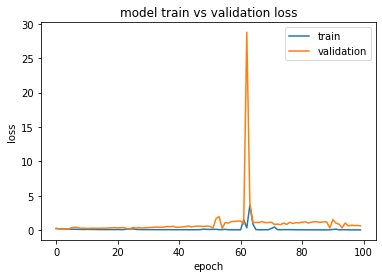

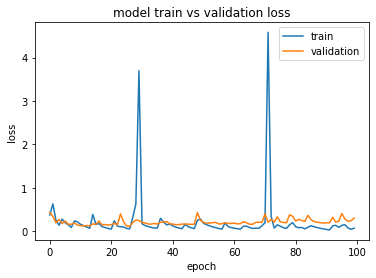

In [20]:
for history in histories:
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model train vs validation loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper right')
  plt.show()

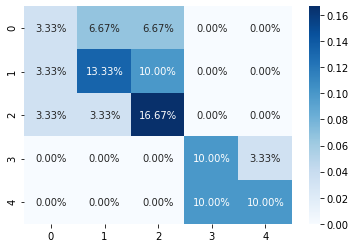

In [21]:
  predictions_test = model.predict(x_test,verbose=0)
  np.round(predictions_test)
  rounded_labels_test = np.argmax(y_test, axis=1)
  rounded_predictions_test = np.argmax(predictions_test, axis=1)
  cf_test = confusion_matrix(rounded_labels_test,rounded_predictions_test)  # doctest: +SKIP
  sns.heatmap(cf_test/np.sum(cf_test), annot=True, fmt='.2%', cmap='Blues')
